In [1]:
import os
import pandas as pd
import keras
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import tensorflow as tf
import splitfolders
import cv2
import random

## Preprocesamiento de imágenes

### Visualización de imágenes
Comenzamos explorando el dataset, todas las imágenes tienen diferentes tamaños y hay algunas con diferentes orientaciones lo que implicara un trabajo de estandarización más adelante


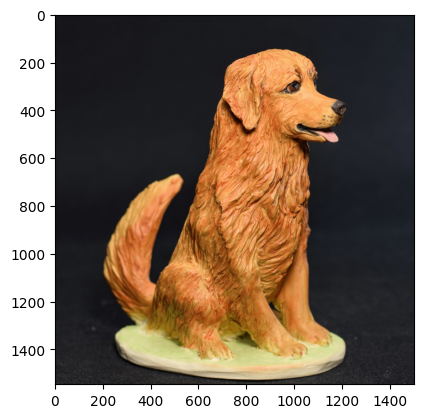

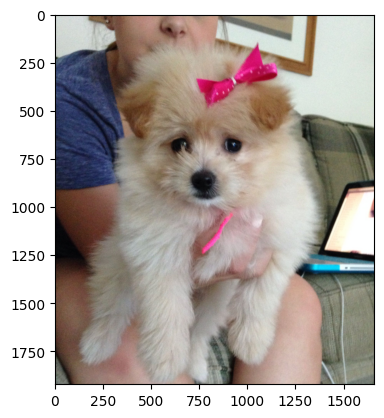

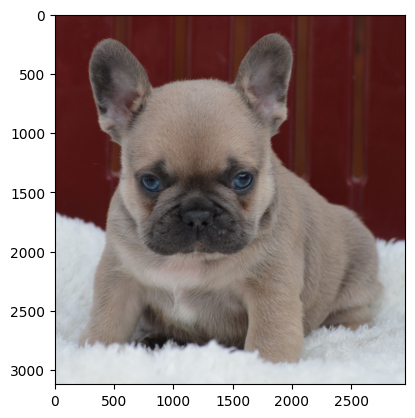

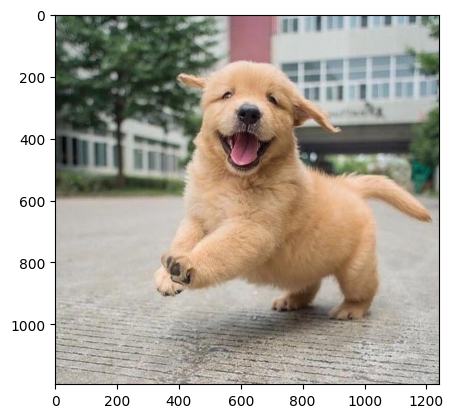

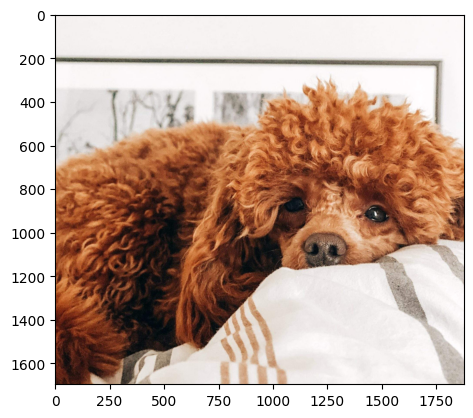

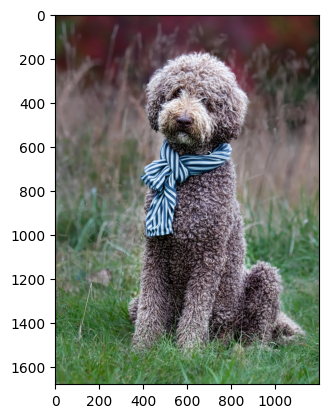

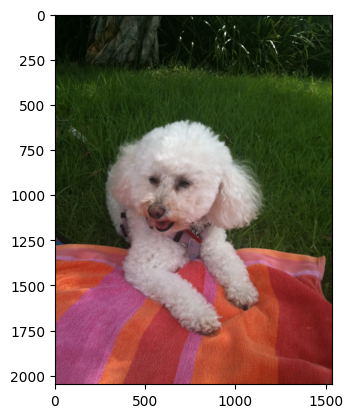

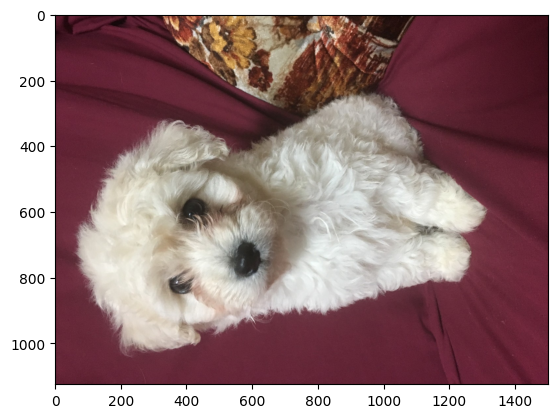

In [2]:

images=[]
perros=[]
for razas in os.listdir('dogs'):
    direct=os.path.join('dogs',razas)
    for i in os.listdir(direct):
        perros2=os.path.join(direct,i)
        perros.append(perros2)

random.shuffle(perros)
for i in range(8):
    img_rgb = cv2.cvtColor(cv2.imread(perros[i]), cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.cvtColor((cv2.imread(perros[i])),cv2.COLOR_BGR2RGB))
    plt.show()




### Creación de directorios para entrenamiento

In [3]:
#Creamos los directorios de entrenamiento testeo y validación
classes=['french_bulldog','german_shepherd','golden_retriever','poodle']
dataset_dir='dogs'
#Se opta por dividir el dataset en 80% entrenamiento, 10% testeo y 10% validación
splitfolders.ratio(dataset_dir, output="output", seed=1337, ratio=(0.8, 0.1,0.1), group_prefix=None) # default values


Copying files: 80 files [00:00, 246.97 files/s]


### Preprocesamiento

Para hacer más robusto el modelo se varia las imagenes de entrenamiento y validación. 
Nota: las imagenes de testeo solo son normalizadas 

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Preprocesamiento de las imagenes para obtener mas variabilidad de las pocas fotos que tenemos
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
test_data_gen = ImageDataGenerator(
                                    rescale=1./255)


### Definición de directorios de entrenamiento

Se definen los directorios de entrenamiento, es imporatnte notar que el  target size de todos es el mismo y que el shuffle en el entrenamiento es verdadero para introducir aun más variabilidad. También ya que vamos a chequear visualmente las imagenes de testeo con las predicciones se guardan con class_mode = none de modo que el directorio de testeo tiene unicamente imgenes escaladas y normalizadas

In [5]:
Batch_size = 8
img_h = 256
img_w = 256
#Por temas de reproducibilidad se fija la semilla
SEED = 1234
tf.random.set_seed(SEED) 
#Se crean los directorios de entrenamitno, testeo y validación 
training_dir = os.path.join('output', 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  
# Validation
valid_dir = os.path.join('output', 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
test_dir = os.path.join('output', 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode=None,
                                           shuffle=False,
                                           seed=SEED)


Found 64 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


### TransferLearning

Debido a la poca información que tenemos entrenar una red neuronal desde el principio sería contraproducente. Con este fin se va a importar una conocida red como ResNet y se le van a agregar otras capas con una salida softmax de 4 clases y entrenarla sobre el conjunto de imagenes acotado que tenemos

In [6]:


#Importamos el  modelo ResNet152V2 y realizamos transfer training, a su vez agregamos capas densa par ala clasificación final y dropout para evitar overfitting
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
     

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#Se fijan los pesos de resnet y se congelan las capas de la red a excepecion de las que agregamos nosotros para finetuneear el modelo
for layer in ResNet_model.layers[:-5]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Definición de función de perdida , optimizador y reductor de learning rate

Se usa una medida estandar como la Crossentropy ya que se trata de un problema de clasificación
El optimizador es ADAM para evitar minimos locales que pueden aparecer con un descenso por gradiente más tipico
La función reduce LROnPlateau tiene el fin de bajar la tasa de aprendizaje si no se ve mejoria en 3 epochs de la val_accuracy. Factor=0,4 simplemente es el factor por el que se reduce esta metrica en caso de no producirse mejoria


In [7]:
#Definimos la función de perdida y el optimizador 
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'],run_eagerly=True)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#Se reduce la tasa de aprendizaje si la accuracy no mejora en 3 epochs
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

## Entrenamiento de modelo

In [9]:
#Definimos tamaño del step para el entrenamiento y validación
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
#Entrenamos el modelo
transfer_learning_history = model.fit(train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                  callbacks=callbacks,verbose=1
                  
                    
)


Epoch 1/20
8/8 [==============================] - 75s 9s/step - loss: 1.2354 - accuracy: 0.5625 - val_loss: 1.8380 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 91s 10s/step - loss: 0.6974 - accuracy: 0.8125 - val_loss: 3.3807 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 74s 9s/step - loss: 0.3530 - accuracy: 0.8438 - val_loss: 0.9320 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 70s 9s/step - loss: 0.3093 - accuracy: 0.8906 - val_loss: 2.5853 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
8/8 [==============================] - 86s 11s/step - loss: 0.2073 - accuracy: 0.9375 - val_loss: 0.8742 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/20
8/8 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9688
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
8/8 [==============================] - 79s 10s/step - loss: 0.1288 - accura

Por temas de velocidad de reproducción, en local decidi guardar este ultimo modelo y volverlo a cargar

In [22]:

#model.save('ultimomodelov2.h5')
#model.save('modelo0604.h5')
model=keras.models.load_model('ultimomodelov2.h5')

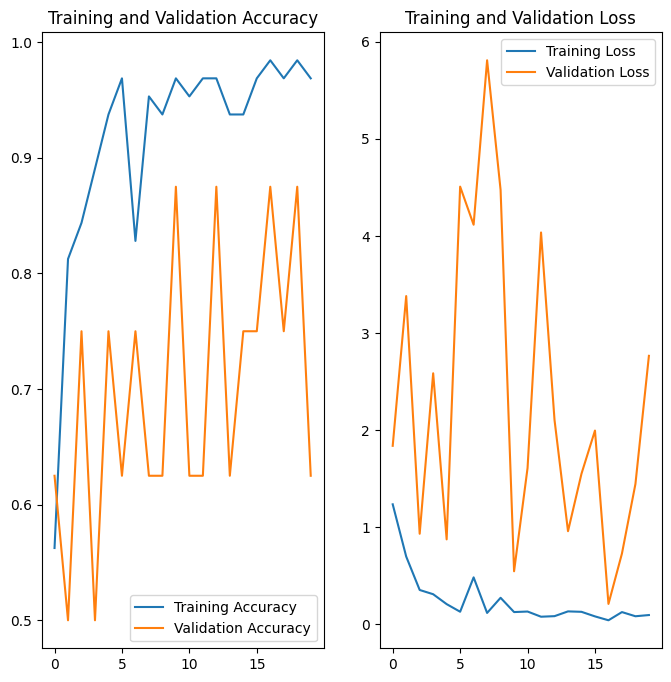

In [11]:
#Visualización de la accuracy y la loss a lo largo de los epochs
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como sanity check evaluamos el modelo en el set de validación recordando que fue distorsionado a proposito y que son 8 imagenes una accuracy de 0.75 parece razonable

In [12]:
valid_gen.reset()
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)


1/1 [==============================] - 4s 4s/step - loss: 0.6977 - accuracy: 0.7500


[0.6977440714836121, 0.75]

### Testeo

Las 8 imagenes sin distorsionar que guardamos para testear fueron clasificadas perfectamente. (Aunque tengo las dudas de si el poodle es un caniche)

1/1 [==============================] - 2s 2s/step


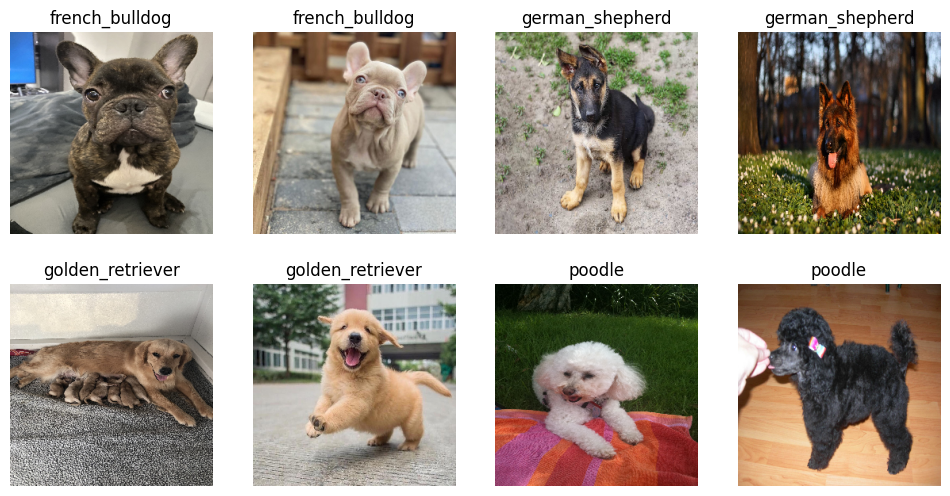

In [31]:
test_gen.reset()
labels = test_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred=model.predict(test_gen,
steps=1,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = test_gen[0][i]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(predictions[i])



## Tratmiento de clase other

No sabemos que puede haber en la clase other asi que debemos intentar crear algo lo más robusto posible

### Alternativa 1: Definir un threshold a partir del cual "confiar" en la clasificación

Se evaluaron imágenes de casos que intentan ser limites(por lo menos desde lo humano). En función a esto se compara la mejor predicción de la capa softmax con este threshold, si la puntuación de la capa softmax es menor al threshold se clasifica como other, sino, se procede normalmente. De esta manera las predicciones cuando nuestro modelo no esta muy seguro de la clasificacion que esta dando pasan a ser other.

In [14]:
def clasificar_imagen(path,threshold):
    path=os.path.join('Pruebas', path)
    img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    predictions=np.argmax(pred,axis=1)
    confianza=np.max(pred)
    if confianza< threshold:
        predictions2='other'
    else:
        predictions2 = [labels[k] for k in predictions]
    plt.show()
    plt.imshow(img)
    plt.title(str(predictions2) + ' ' +str(confianza))
        
    return predictions2, confianza

1/1 [==============================] - 0s 274ms/step


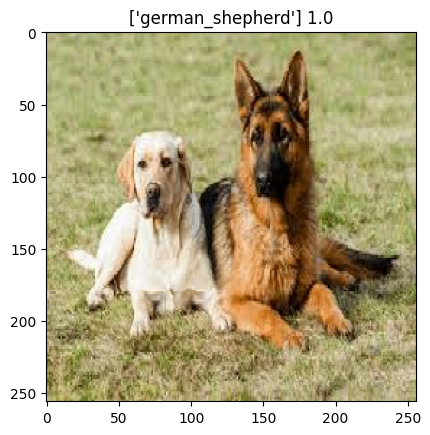

1/1 [==============================] - 0s 288ms/step


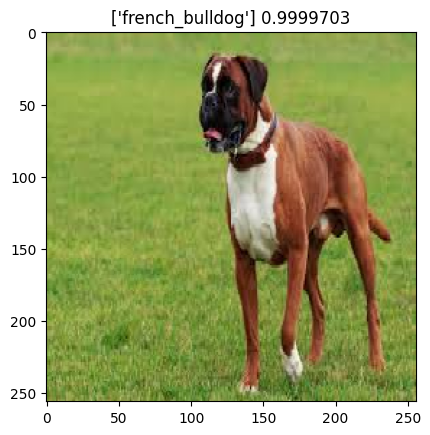

1/1 [==============================] - 0s 273ms/step


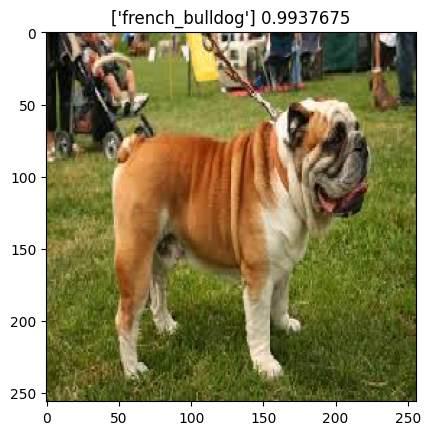

1/1 [==============================] - 0s 276ms/step


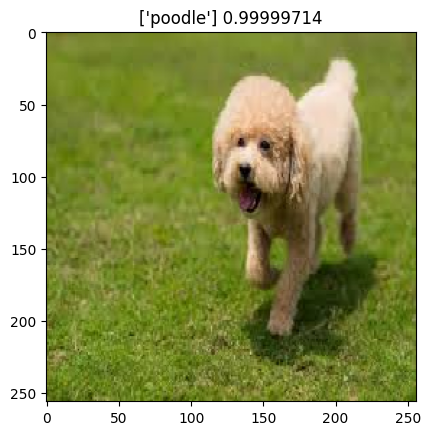

1/1 [==============================] - 0s 262ms/step


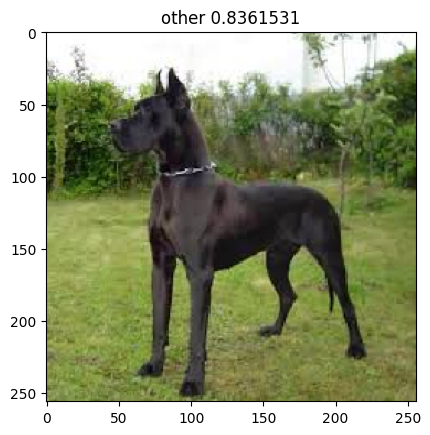

1/1 [==============================] - 0s 272ms/step


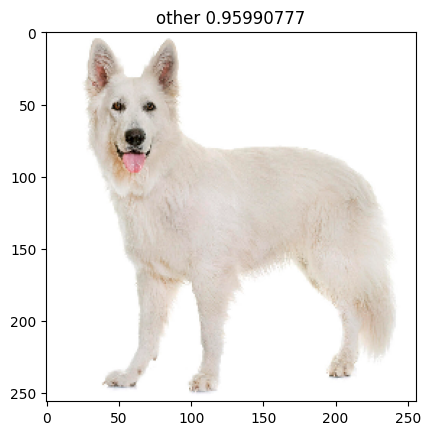

1/1 [==============================] - 0s 273ms/step


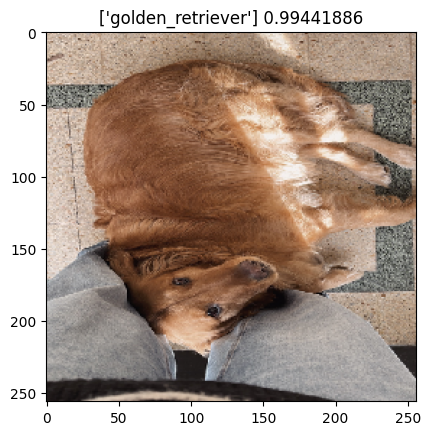

1/1 [==============================] - 0s 287ms/step


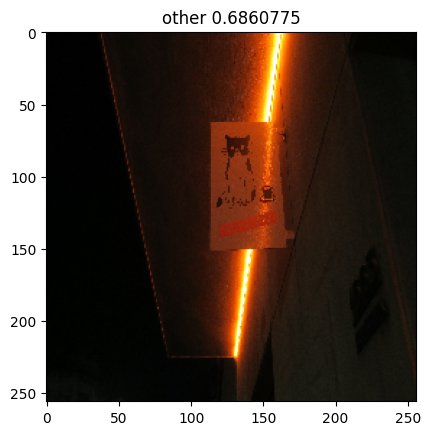

1/1 [==============================] - 0s 301ms/step


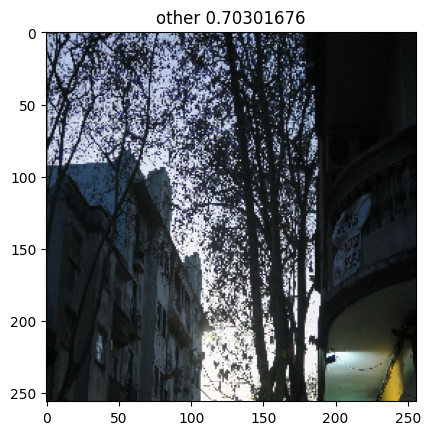

1/1 [==============================] - 0s 259ms/step


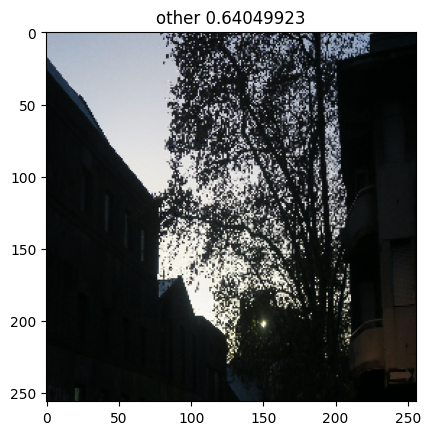

1/1 [==============================] - 0s 278ms/step


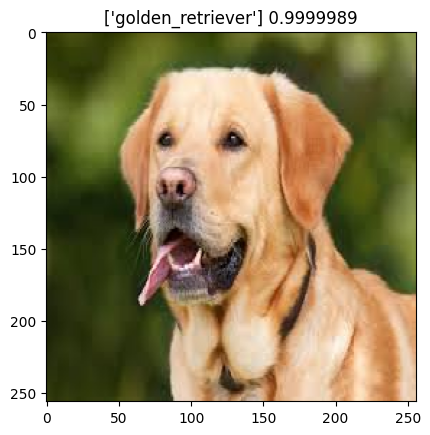

1/1 [==============================] - 0s 287ms/step


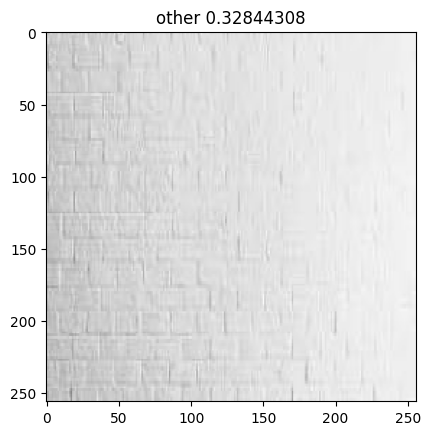

1/1 [==============================] - 0s 298ms/step


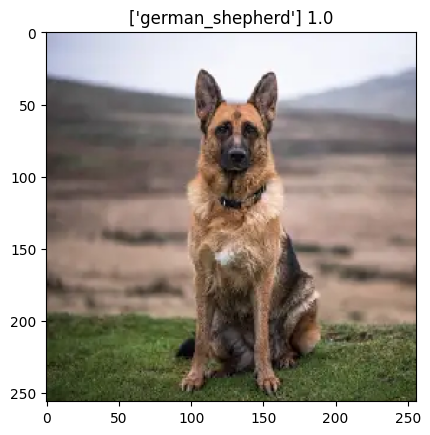

1/1 [==============================] - 0s 306ms/step


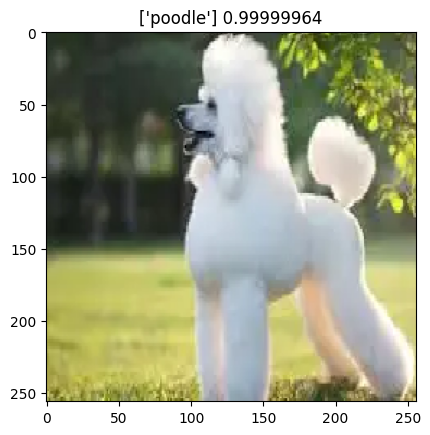

1/1 [==============================] - 0s 289ms/step


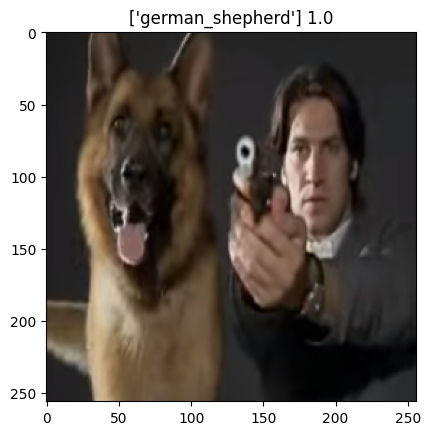

1/1 [==============================] - 0s 262ms/step


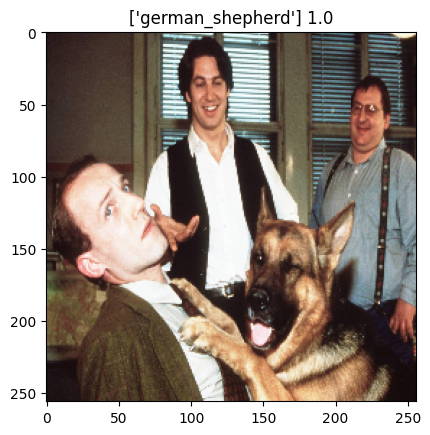

1/1 [==============================] - 0s 275ms/step


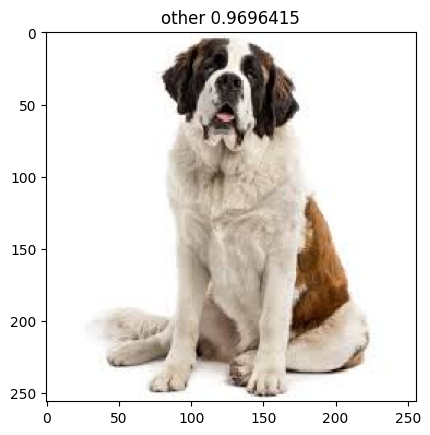

1/1 [==============================] - 0s 268ms/step


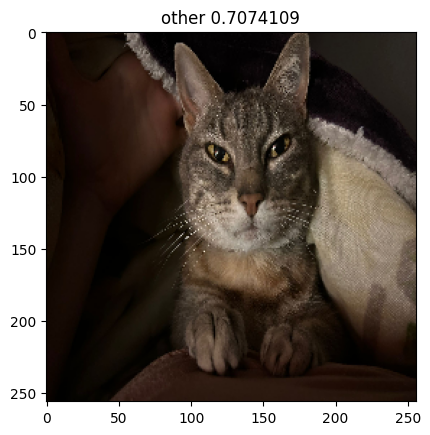

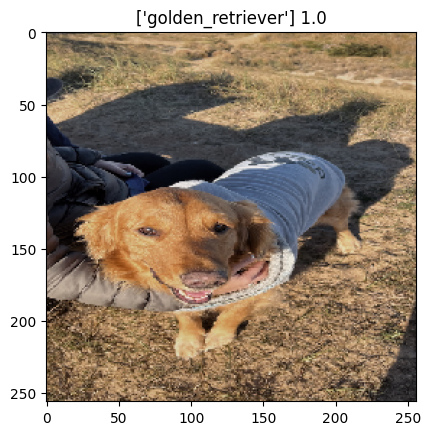

In [27]:
for i in os.listdir('Pruebas'):
    clasificar_imagen(i,0.97)

### Alternativa 2: Construir una red neuronal para clasificar en other

Se podria generar una red neuronal que decida si una imagen esta dentro de las 4 clases que ya tenemos o no lo esta. Para esto se combinarian todas las imagenes que tenemos de perros en un nuevo set de entrenamiento y se conseguiria un dsetataset representativo de lo que puede ser esa clase other. A su vez usaría TransferLearning y rentrenaria un modelo similar al usado en la clasificación pero con una salida sigmoide. Para este caso posiblemente usaría una red neuronal más chica como lo puede ser MobileNetV3Small

Abajo el modelo sugerido a entrenar

In [16]:
MobileNet = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#Se fijan los pesos de resnet y se congelan las capas de la red a excepecion de las que agregamos nosotros para finetuneear el modelo



x = MobileNet.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output = Dense(units=1, activation='sigmoid')(x)



model = Model(MobileNet.input, output)

MobileNet.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   